<a href="https://colab.research.google.com/github/Wojtek130/Neural-Networks/blob/main/nn_Assignment5_ex5_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose
from torchvision.utils import save_image
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!gdown https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/triangle.npy
bird_images = np.load("triangle.npy").reshape(-1, 784)



Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/triangle.npy
To: /content/triangle.npy
100% 96.6M/96.6M [00:01<00:00, 90.0MB/s]


In [ ]:
class NumpyDataset(Dataset):
    def __init__(self, images):
        self.images = torch.from_numpy(images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [ ]:
birds_dataset = NumpyDataset(bird_images)
batch_size = 16
birds_dataloader = DataLoader(birds_dataset, batch_size=batch_size)
birds_dataloader

In [ ]:
for imgs in birds_dataloader:
    print(imgs.shape)
    break

torch.Size([16, 784])


In [ ]:
# def save_fake_images(index):
#     x_log_var = 5
#     x_mu = 3
#     x_shape = 784
#     x_recon = torch.randn(x_shape).to(device) * torch.exp(x_log_var / 2) + x_mu
#     x_recon = x_recon.cpu()
#     plt.imshow(img_batch[0][0], cmap='gray')
#     fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
#     fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
#     print('Saving', fake_fname)
#     save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [ ]:
# for imgs in birds_dataloader:
#     print(imgs[0].shape)
#     save_and_show_image(imgs[0], epoch = 1)
#     break

## Moon dataset

In [ ]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [ ]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

<ipython-input-84-e26e9d29dce2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = [torch.tensor(tensor) for tensor in tensors]


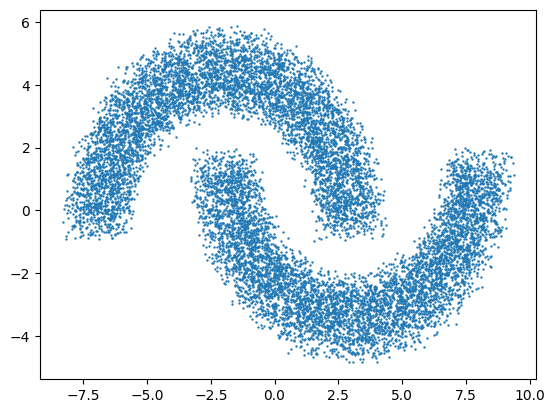

In [ ]:
moons = generate_moons(width=1.0)

moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

In [ ]:
for x in moons_dl:
    print(len(x))
    print(x)
    print(x[0].shape)
    break

1
(tensor([[ 1.1218, -3.4095],
        [-1.0062,  4.2951],
        [ 4.3827, -1.7799],
        ...,
        [ 2.0667,  0.3399],
        [-3.6271,  4.7030],
        [ 2.7165,  2.0194]], device='cuda:0'),)
torch.Size([2048, 2])


In [ ]:
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, in_dim),
        )

        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def encode(self, x):
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        sampled_z = z_mu + eps * std
        return sampled_z, z_mu, z_log_var

    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

    def forward(self, x):
        z, z_mu, z_log_var = self.encode(x)
        x_mu, x_log_var = self.decode(z)
        return x_mu, x_log_var, z_mu, z_log_var

def loss_function(x, x_mu, x_log_var, z_mu, z_log_var):
    recon_loss = 0.5 * torch.sum(x_log_var + ((x - x_mu) ** 2) / torch.exp(x_log_var))
    kl_div = -0.5 * torch.sum(1 + z_log_var - z_mu.pow(2) - z_log_var.exp())
    return recon_loss + kl_div

In [ ]:
def gaussian_negative_log_likelihood(x, mu, log_var):
    """Compute N(x; mu=mu, sigma^2=exp(log_var)^2)."""
    return 0.5 * torch.sum(log_var + ((x - mu) ** 2) / torch.exp(log_var))

def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2):
    """Compute KL divergence between two Gaussian distributions."""
    return 0.5 * torch.sum(log_var2 - log_var1 + (torch.exp(log_var1) + (mu1 - mu2).pow(2)) / torch.exp(log_var2) - 1)

def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negative log-likelihood reconstruction loss:
       1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    return gaussian_negative_log_likelihood(real_x, predicted_x_mu, predicted_x_log_var)

def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1)."""
    return -0.5 * torch.sum(1 + z_log_var - z_mu.pow(2) - z_log_var.exp())

In [ ]:
## Training the VAE
z_dim = 784
hid_dim = 64
# z_dim = 2
lr = 0.0003

vae = VAE(in_dim=z_dim, hid_dim=128, z_dim=z_dim).to(device)
# vae = VAE(in_dim=z_dim, hid_dim=1024, z_dim=z_dim)

optimizer = optim.Adam(vae.parameters(), lr=lr)

In [ ]:
sample_vectors = torch.randn(100, z_dim).to(device)


def save_and_show_image(filename='fake-image', epoch = None):
    # fake_images = vae(sample_vectors)
    # filename = f"{filename}-{epoch}.png" if epoch is not None else f"{filename}.png"
    # save_image(fake_images, os.path.join("samples", filename), nrow=10)
    x_gen_mu, x_gen_log_var = vae.decode(sample_vectors)
    x_gen = (
        torch.randn(sample_vectors.shape[0], 784).to(device) * torch.exp(x_gen_log_var / 2)
        # torch.randn(sample_vectors.shape[0], 784).to(device) * torch.exp(x_gen_log_var / 784)

        + x_gen_mu
    )
    x_gen = x_gen.cpu()
    fake_images = x_gen.reshape(x_gen.size(0), 1, 28, 28)
    print(fake_images.shape)
    filename = f"{filename}-{epoch}.png" if epoch is not None else f"{filename}.png"
    save_image(fake_images, os.path.join("", filename), nrow=10)
    # image_tensor_reshaped = image_tensor.view(28, 28)
    # image_array = image_tensor_reshaped.numpy()
    # plt.imshow(image_array, cmap='gray')
    # plt.title("Reshaped 28x28 Image")
    # plt.axis('off')  # Hide the axis
    # plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    # plt.show()

In [ ]:
def reconstruct_and_generate(vae,filename_reconstructed='reconstructed_image.png', epoch = 1500):

    # Set the model to evaluation mode
    vae.eval()

    with torch.no_grad():
        # Reshape to (1, 784) to match the input shape of the network
        # image_tensor = image_tensor.view(1, 784).to(device)

        # Reconstruct the image
        # reconstructed_image, _, _, _ = vae(image_tensor)
    #     reconstructed_image = reconstructed_image.view(28, 28).cpu().numpy()

    #     # Generate a new image by sampling from the latent space
        sampled_z = torch.randn(1, vae.z_dim).to(device)
        generated_image, _ = vae.decode(sampled_z)
        generated_image = generated_image.view(28, 28).cpu().numpy()

    # Plot and save the reconstructed image
    plt.imshow(generated_image, cmap='gray')
    plt.title("Generated Image")
    plt.axis('off')
    plt.savefig(f'generated_image-{epoch}.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f"image saved, epoch: {epoch}")

In [ ]:
# for x in birds_dataset:
#   # print(x.shape, x.dtype)
#   reconstruct_and_generate(vae, x)
#   break

```
Epoch: 0 loss: 15.3017 recon_loss: 15.0352 kl_loss: 0.2665 avg mean: -0.0953 avg std: 1.0014
Epoch: 200 loss: 4.9773 recon_loss: 2.7884 kl_loss: 2.1889 avg mean: -0.0305 avg std: 0.3532
Epoch: 400 loss: 4.9074 recon_loss: 2.7315 kl_loss: 2.1758 avg mean: -0.0215 avg std: 0.3687
Epoch: 600 loss: 4.8669 recon_loss: 2.6247 kl_loss: 2.2422 avg mean: -0.0549 avg std: 0.3756
Epoch: 800 loss: 4.8175 recon_loss: 2.4267 kl_loss: 2.3908 avg mean: 0.0281 avg std: 0.3628
Epoch: 1000 loss: 4.7753 recon_loss: 2.2255 kl_loss: 2.5498 avg mean: -0.0461 avg std: 0.3532
```

Monitor the loss and the generated data.
Stop when the loss converges and data generation is satisfactory.

Epoch: 0 loss: 1032718.0910 recon_loss: 913982.3585 kl_loss: 118735.7325 avg mean: 0.0090 avg std: 0.7782


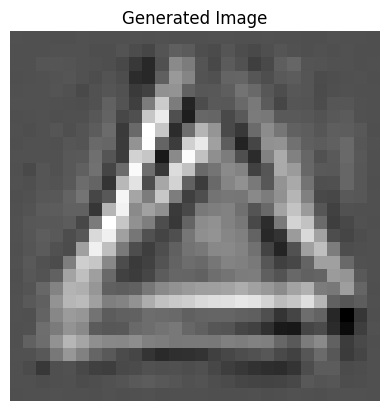

image saved, epoch: 0
Epoch: 20 loss: 340747.7205 recon_loss: 333594.6666 kl_loss: 7153.0539 avg mean: -0.0004 avg std: 0.9655


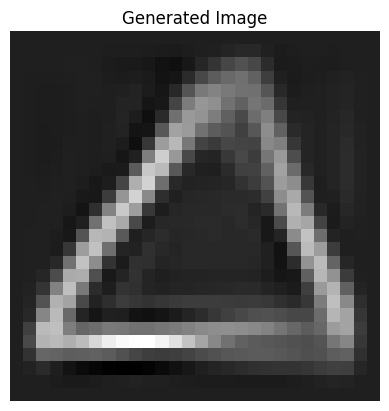

image saved, epoch: 20
Epoch: 40 loss: 323735.1401 recon_loss: 316986.6536 kl_loss: 6748.4865 avg mean: -0.0020 avg std: 0.9697


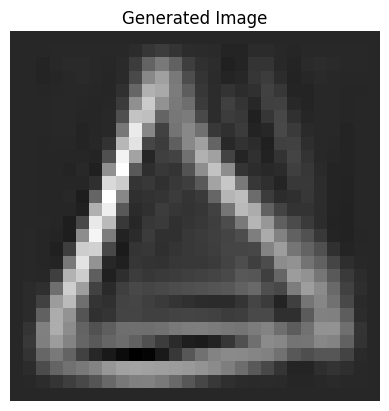

image saved, epoch: 40
Epoch: 60 loss: 315877.5243 recon_loss: 309246.8176 kl_loss: 6630.7067 avg mean: 0.0001 avg std: 0.9745


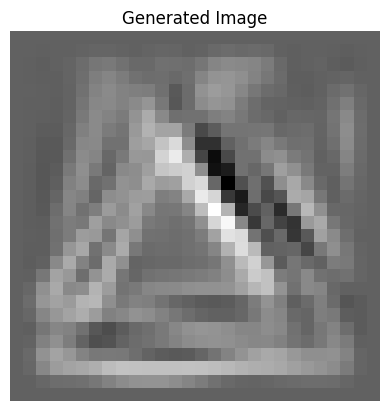

image saved, epoch: 60
Epoch: 80 loss: 312123.4471 recon_loss: 305532.2032 kl_loss: 6591.2440 avg mean: -0.0038 avg std: 0.9738


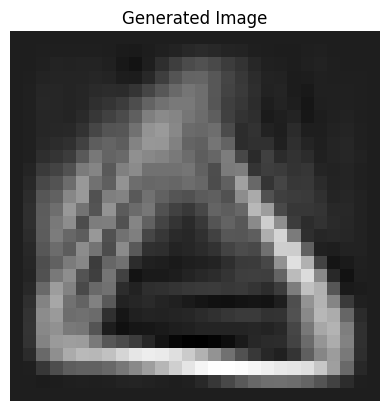

image saved, epoch: 80
Epoch: 100 loss: 307724.3955 recon_loss: 301280.2880 kl_loss: 6444.1074 avg mean: -0.0074 avg std: 0.9776


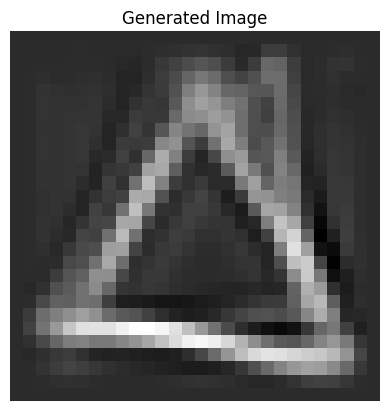

image saved, epoch: 100


KeyboardInterrupt: 

In [ ]:
# Please note: the model should converge faster!
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x in birds_dataloader:
        x = x.float().to(device)
        # x -> Encoder(x) -> z_mu, z_log_var -> Decoder(z_mu, z_log_var) -> x_mu, x_log_var

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 20 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            reconstruct_and_generate(vae, epoch=i)
            # x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            # x_recon = x_recon.cpu()

            # plt.scatter(x_recon[:, 0], x_recon[:, 1])
            # plt.title("Reconstruction")
            # plt.show()

            # # Generate new data
            # z = torch.randn(500, z_dim).to(device)
            # x_gen_mu, x_gen_log_var = vae.decode(z)
            # x_gen = (
            #     torch.randn(z.shape[0], 784).to(device) * torch.exp(x_gen_log_var / 2)
            #     + x_gen_mu
            # )
            # x_gen = x_gen.cpu()

            # plt.scatter(x_gen[:, 0], x_gen[:, 1])
            # plt.title("Generation")
            # plt.show()
            # save_and_show_image(epoch=i)

In [ ]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")

vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
with torch.no_grad():
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

    z_mu_data, _ = torch.chunk(vae.encoder(data_tensor), 2, dim=1)
    z_mu_grid, _ = torch.chunk(vae.encoder(grid_tensor), 2, dim=1)

enc_grid = z_mu_grid.cpu().numpy()
enc_data = z_mu_data.cpu().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")